In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("cs1090b_hw3.ipynb")

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 
## Homework 3: Convolutional Neural Networks


**Harvard University**<br/>
**Spring 2025**<br/>
**Instructors**: Pavlos Protopapas, Natesh Pillai, and Chris Gumb


<hr style="height:2pt">

In [2]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/"
    "content/styles/cs109.css"
).text
HTML(styles)

In [3]:
try:
    import tensorflow_datasets as tfds
except ImportError:
    print("Installing tensorflow-datasets...")
    !pip install -q --no-warn-script-location tensorflow-datasets==4.9.4
    print("Done!\n⚠️ Please restart kernel for changes to take effect (Kernel > Restart)")

In [4]:
import os
import pathlib
import time
import zipfile
import random
import imageio
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time
import tarfile
import gdown
from PIL import Image
import requests
import scipy.ndimage as ndimage
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Activation, BatchNormalization, Add
from tensorflow.keras.layers import Conv2D, Dense, Dropout, GaussianNoise
from tensorflow.keras.layers import Flatten, Input, MaxPooling2D, GlobalAveragePooling2D, AveragePooling2D, Concatenate, UpSampling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.metrics import MeanIoU # didn't work
import tqdm

2025-04-02 15:17:50.058333: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-02 15:17:50.058371: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-02 15:17:50.059104: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-02 15:17:50.064329: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# TF GPU check
print(f"tensorflow version {tf.__version__}")
print(f"Available GPUs: \n{tf.config.list_logical_devices('GPU')}\n")

tf.random.set_seed(2266)

tensorflow version 2.15.0
Available GPUs: 
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]



2025-04-02 15:17:56.029472: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20763 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:31:00.0, compute capability: 8.9


In [6]:
# measure notebook runtime
time_start = time.time()

<div style = "background: lightsalmon; border: thin solid black; border-radius: 2px; padding: 5px">

### Instructions
- To submit your notebook, follow the instructions given in on the Canvas assignment page.
- Plots should be legible and interpretable *without having to refer to the code that generated them*. They should includelabels for the $x$- and $y$-axes as well as a descriptive title and/or legend when appropriate.
- When asked to interpret a visualization, do not simply describe it (e.g., "the curve has a steep slope up"), but instead explain what you believe the plot *means*.
- Autograding tests are mostly to help you debug. The tests are not exhaustive so simply passing all tests may not be sufficient for full credit.
- The use of *extremely* inefficient or error-prone code (e.g., copy-pasting nearly identical commands rather than looping) may result in only partial credit.
- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. Please get course staff approval before importing any additional 3rd party libraries.
- Enable scrolling output on cells with very long output.
- Feel free to add additional code or markdown cells as needed.
- Ensure your code runs top to bottom without error and passes all tests by restarting the kernel and running all cells (note that this can take a few minutes). 
- **You should do a "Restart Kernel and Run All Cells" before submitting to ensure (1) your notebook actually runs and (2) all output is visible**
</div>


<a id="contents"></a>

## Notebook Contents

- [**PART 1: Building a Basic CNN Classifier**](#part1)

- [**PART 2: Regression with CNN**](#part2)

- [**PART 3: Image Segmentation**](#part3)

## About this Homework

In this homework, we will explore Convolutional Neural Networks (CNNs).

- In [PART 1](#part1), we will begin by building a CNN to classify CIFAR-10 images, a standard pedagogical problem.


- Then, in [PART 2](#part2), we will then see that CNNs are great for more than just classifying our images! They can serve as image input processing for a variety of tasks, as we will show by training a network on the CelebA dataset to rotate images of faces upright.

- Finally, [PART 3](#part3), we will look at a dataset of pet photos for image segmentation. This is a classification problem. But instead of assigning class probablities to the image as a whole, we assign class probabilities for each individual pixel, identifying what regions of the image belong to each class (e.g., 'pet' or 'background').  

**IMPORTANT NOTES:**

- Convolutional neural networks are computationally intensive.
- **We highly recommend that you train your model on a system using GPUs. For this, we recommend using the [GPU-enabled Jupyter environment](https://ood.huit.harvard.edu/pun/sys/dashboard/batch_connect/sys/ood-jupyterlab-spack-conda/cs1090b/session_contexts/new) provided to you as part of this course.** 
- Models that take hours to train on CPUs can be trained in just minutes when using GPUs.
- **To avoid getting frustrated by having to re-train your models every time you run your notebook, you should save your trained model weights for later use.** Model history dictionaries can also be saved to disk with `pickle` and checked with an `if not` condition. This is a great way to check if the model weights exist before training, preventing redundant retraining. Please, think of the penguins! 🐧

**KERNEL CRASHES:**

If your kernel crashes as you attempt to train your model, please check the following items:
- Models with too many parameters might not fit in GPU memory. Try reducing the size of your model.
- A large `batch_size` will attempt to load too many images in GPU memory. Avoid using a very large batch size.
- Avoid creating multiple copies of the data.

<a id="part1"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

# PART 1: Building a Basic CNN Model


<a id="part1intro"></a>

## Overview

[Return to contents](#contents)

In this question, you will use Keras to create a convolutional neural network for predicting the "type of object" shown in each image from the [CIFAR-10](https://keras.io/datasets/#cifar10-small-image-classification) dataset. This dataset contains 50,000 32x32 colored training images and 10,000 test images of the same size, with a total of 10 classes, representing the "type of object" shown in each image.

<a id="q11"></a>



<!-- BEGIN QUESTION -->

<div class='exercise'>
    
<b>1.1 Loading CIFAR-10 and Constructing the Model</b>
<hr>
<b>Q1.1.1 - Preprocessing</b>

<a id="q111"></a>

Load the CIFAR-10 dataset from the `tensorflow.keras.datasets.cifar10` import shown at the top of this notebook. Perform any preprocessing of the data that might be required for this dataset.
    
You may choose to load cifar10 as either a numpy array or as a Tensorflow Dataset.
</div>

In [7]:
# load data (separate cell block to avoid constantly rerunning it)
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [8]:
# normalizing image data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# - preprocessing - #

# one-hot encode classes
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# augment data
datagen = ImageDataGenerator(
    rotation_range=20, 
    width_shift_range=0.1, 
    height_shift_range=0.1,  
    horizontal_flip=True, 
    zoom_range=0.1 
)
datagen.fit(x_train)

# confirm shapes
print("Training data shape:", x_train.shape)
print("Training labels shape:", y_train.shape)
print("Test data shape:", x_test.shape)
print("Test labels shape:", y_test.shape)

Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 10)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000, 10)


<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.1.2</b>

<a id="q112"></a>

Construct a classification model architecture using a combination of the following layers: Conv2D, MaxPooling2D, Dense, Dropout and Flatten. The layers don’t necessarily need to be in this order, and you can use as many of these types of layers as you’d like. 

  - You may choose to construct your own implementation of a well-known architecture like AlexNet or VGG16, or you can create an architecture of your own devising.

  - However, you MUST code the network yourself and not use a pre-written implementation. 

  - You must have multiple Conv2D layers.
</div>

In [9]:
# VGG16-esque model; I didn't think a 5th block was necessary for this problem
def model_112(n_filters = 64, n_classes=10):
    model = Sequential()
    
    # 1st convolution block
    model.add(Conv2D(n_filters, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(n_filters, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(strides=(2, 2)))
    
    # 2nd convolution block
    model.add(Conv2D(n_filters * 2, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(n_filters * 2, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(strides=(2, 2)))
    
    # 3rd convolution block
    model.add(Conv2D(n_filters * 4, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(n_filters * 4, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(n_filters * 4, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(strides=(2, 2)))
    
    # 4th convolution block
    model.add(Conv2D(n_filters * 8, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(n_filters * 8, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(n_filters * 8, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(strides=(2, 2)))
    
    # FC layers
    model.add(Flatten())
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation='softmax'))
    
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model_1 = model_112()
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 128)         0         
 g2D)                                                   

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.2 Model parameter growth</b>

<a id="q12"></a>

How does the number of total parameters change (e.g. linearly, exponentially, etc.) as the number of filters per layer increases (your model should have at least 2 Conv layers)? You can find this empirically by constructing multiple models with the same type of architecture and increasing the number of filters. Generate a plot showing the relationship and explain why it has this relationship. 

**HINT:** Completing this question is far easier if you write a function that generates your desired architecture in 1.1.2, with arguments that allow you to easily rebuild the architecture with varying numbers of filters per layer.
    </div>

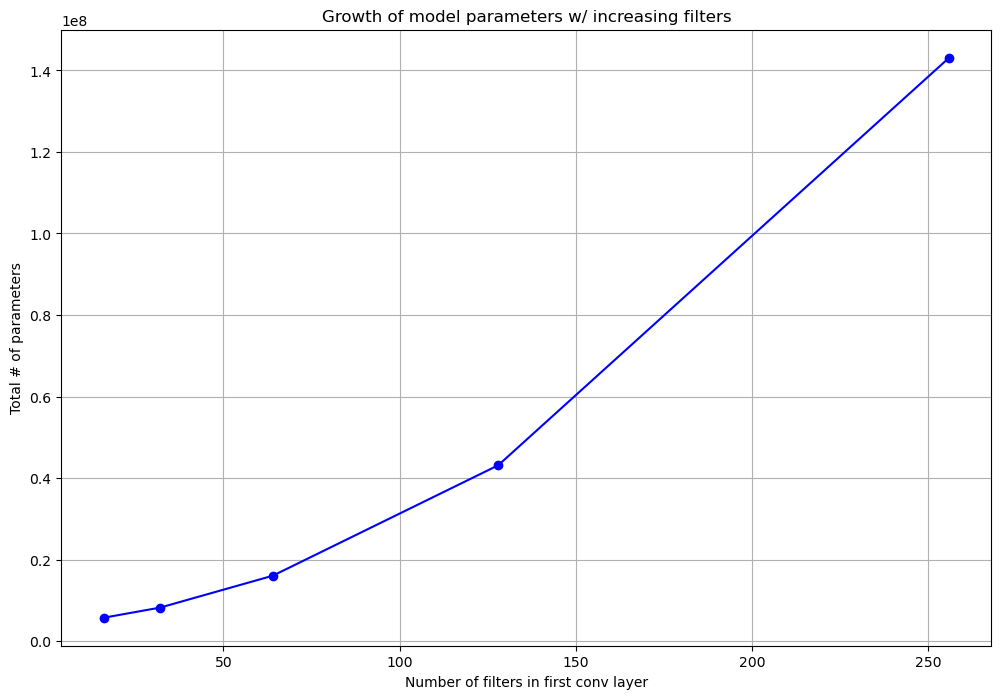

In [10]:
# different filter sizes
filter_sizes = [16, 32, 64, 128, 256]
num_params = []

for filters in filter_sizes:
    model = model_112(filters)
    num_params.append(model.count_params())

# plotting parameter growth
plt.figure(figsize=(12, 8))
plt.plot(filter_sizes, num_params, marker='o', linestyle='-', color='b')
plt.xlabel('Number of filters in first conv layer')
plt.ylabel('Total # of parameters')
plt.title('Growth of model parameters w/ increasing filters')
plt.grid()
plt.show()


# Answer

As we increase the number of filters in the first convolutional layer, the total number of parameters in the model grows rapidly. This happens because each Conv2D layer's parameters are calculated as (filter height × filter width × input channels + 1) multiplied by the number of filters, and since subsequent layers often use multiples of the initial filter count (e.g., 2×, 4×, 8×), the parameter count increases multiplicatively rather than linearly.

Additionally, the increased number of filters leads to a larger flattened output that feeds into the dense layers, which further amplifies the total parameter count. Dense layers are fully connected, so their parameters scale with the product of the input size and the number of neurons, compounding the rapid growth. Together, these effects result in a superlinear—almost exponential—increase in model parameters as the base number of filters increases.

<a id="q13"></a>


<!-- BEGIN QUESTION -->

<div class='exercise'>

<b>1.3 Choose a model, train and evaluate it</b>
<hr>    
<b>Q1.3.1</b>

<a id="q131"></a>

Print the model summary for your chosen architecture, and report the total number of parameters. Then train your model using the CIFAR-10 dataset, and `validation_split=0.2`. You can choose to train your model for as long as you'd like, but you should aim for at least 10 epochs. Report your validation and test accuracies. You can achieve a test accuracy of over 75% in about 6 minutes of training.

**Hint:** It would be helpful to add code which either saves your model to a local directory if it is the first time you're training it or loads your model if a saved file version currently exists in that directory. This will not only help save time when you rerun your notebook, but it will also ensure reproducible results in the rest of Part 1.
</div>

In [11]:
# save the penguins (by loading the model from trained weights)
model_file = 'model/my_cifar10_model.h5'

# create validation splits
validation_split = 0.2
split_index = int(len(x_train) * (1 - validation_split))
x_train_new, x_val = x_train[:split_index], x_train[split_index:]
y_train_new, y_val = y_train[:split_index], y_train[split_index:]

if os.path.exists(model_file):
    print("Loading saved model from", model_file)
    model = load_model(model_file)
    
else:
    print("No saved model found. Creating and training a new model.")
    # create your model using model function from earlier
    model = model_112()
    
    # print summary and report total params
    model.summary()
    print("Total number of parameters:", model.count_params())
    
    # create data generators
    train_generator = datagen.flow(x_train_new, y_train_new, batch_size=64)
    val_generator   = datagen.flow(x_val, y_val, batch_size=64)
    
    # train model
    history = model.fit(train_generator,
                        validation_data=val_generator,
                        epochs=20,    
                        verbose=1)
    
    # save the trained model
    model.save(model_file)
    print("Model saved to", model_file)

No saved model found. Creating and training a new model.
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 conv2d_61 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 16, 16, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_62 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 conv2d_63 (Conv2D)          (None, 16, 16, 128)       147584    
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 8, 8, 128)         0       

2025-04-02 15:17:59.205749: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-04-02 15:18:00.349134: I external/local_xla/xla/service/service.cc:168] XLA service 0x150f94cf34b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-02 15:18:00.349163: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9
2025-04-02 15:18:00.353978: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743621480.431451    6920 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 [==============================] - 20s 24ms/step - loss: 1.8977 - accuracy: 0.2603 - val_loss: 1.6069 - val_accuracy: 0.3904
Epoch 2/20
625/625 [==============================] - 15s 24ms/step - loss: 1.5301 - accuracy: 0.4270 - val_loss: 1.4555 - val_accuracy: 0.4666
Epoch 3/20
625/625 [==============================] - 15s 24ms/step - loss: 1.3422 - accuracy: 0.5080 - val_loss: 1.1935 - val_accuracy: 0.5710
Epoch 4/20
625/625 [==============================] - 15s 24ms/step - loss: 1.2043 - accuracy: 0.5626 - val_loss: 1.1779 - val_accuracy: 0.5696
Epoch 5/20
625/625 [==============================] - 15s 24ms/step - loss: 1.0893 - accuracy: 0.6096 - val_loss: 1.1296 - val_accuracy: 0.6046
Epoch 6/20
625/625 [==============================] - 15s 24ms/step - loss: 1.0081 - accuracy: 0.6411 - val_loss: 1.0198 - val_accuracy: 0.6375
Epoch 7/20
625/625 [==============================] - 15s 24ms/step - loss: 0.9333 - accuracy: 0.6683 - val_loss: 0.9505 - val_accuracy: 0.6634
Epo

/shared/courseSharedFolders/142601outer/142601/cs109b/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to model/my_cifar10_model.h5


In [12]:
# evaluate and report accuracies
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=1)

print("Test accuracy:", test_acc)
print("Val accuracy:", history.history['val_accuracy'][-1]) # history is dependent on the model being trained

313/313 [==============================] - 1s 3ms/step - loss: 0.5653 - accuracy: 0.8141
Test accuracy: 0.8141000270843506
Val accuracy: 0.8046000003814697


<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.3.2</b>

<a id="q132"></a> 

Plot the training loss and accuracy per epoch (both train and validation) for your chosen architecture.

</div>

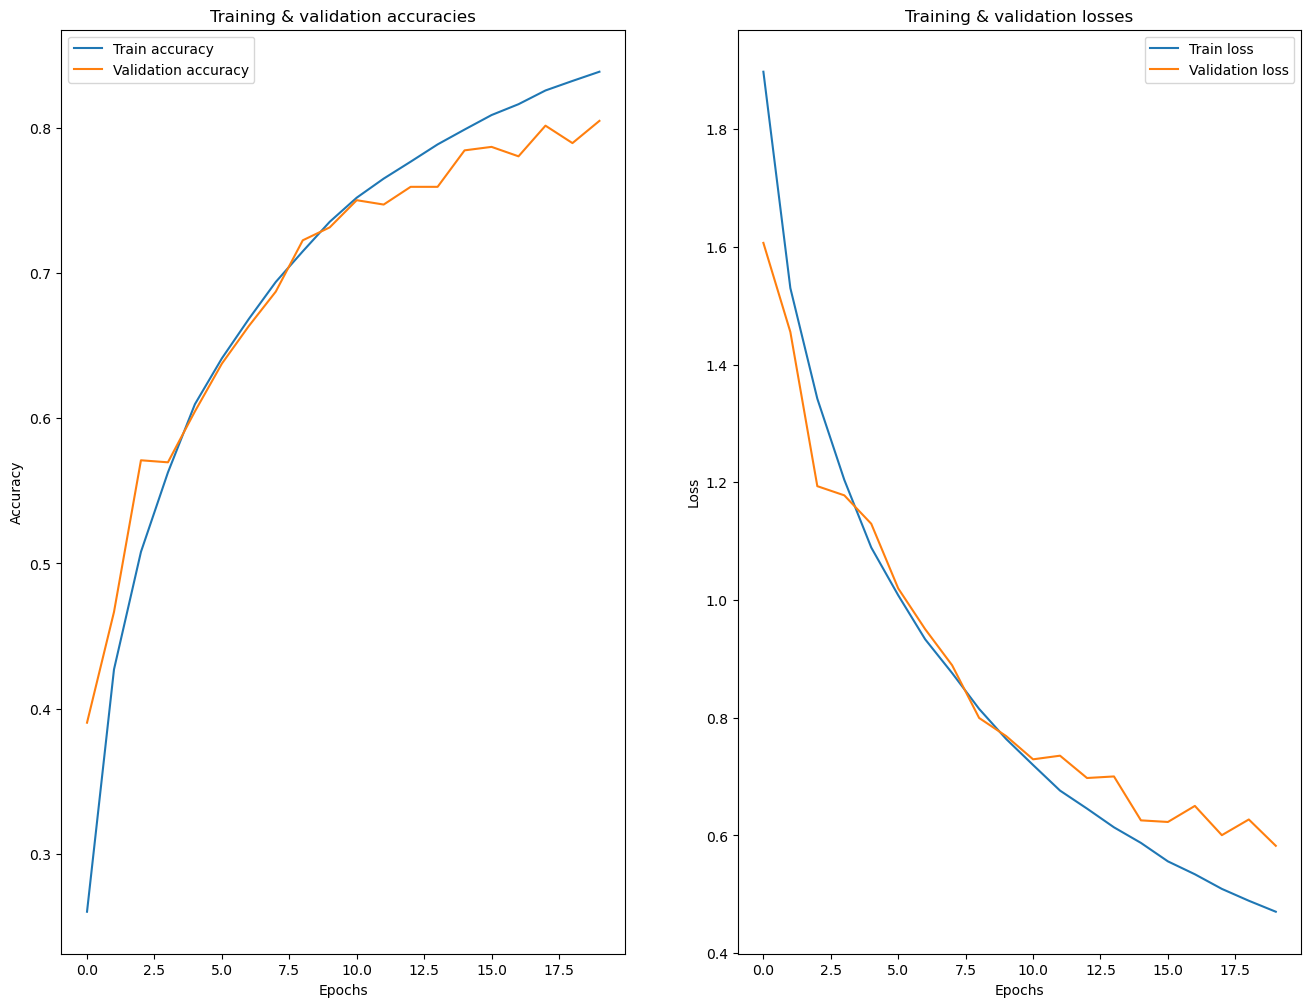

In [13]:
# plot
plt.figure(figsize=(16, 12))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & validation accuracies')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & validation losses')
plt.legend()

plt.show()

<a id="part2"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

# PART 2: Regression with CNN 
<a id="part2intro"></a>
## Overview

[Return to contents](#contents)

**In this problem we will construct a neural network to predict how far a face is from being "upright"**. 

**Image orientation estimation**

Image orientation estimation with convolutional networks was first implemented in 2015 by Fischer, Dosovitskiy, and Brox in a paper titled ["Image Orientation Estimation with Convolutional Networks"](https://lmb.informatik.uni-freiburg.de/Publications/2015/FDB15/image_orientation.pdf). In that paper, the authors trained a network to straighten a wide variety of images using the [Microsoft COCO dataset](https://cocodataset.org/#home). 

**The modified CelebA dataset**

In order to have a reasonable training time for a homework, we will be working on a subset of the problem where we just straighten images of faces. To do this:

- We will be using the [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset of celebrity faces, where we assume that professional photographers have taken level pictures;


- The training will be supervised, with a rotated image (up to $\pm 60^\circ$) as an input, and the amount (in degrees) that the image has been rotated as a target. 

<a id="q21"></a>


<!-- BEGIN QUESTION -->

<div class='exercise'>
<b>2.1 Data preparation</b>
<hr>
<b>Q2.1.1</b>

<a id="q211"></a>

**Loading the CelebA Dataset.** Run the cells provided to automatically load the CelebA dataset if you are on the cluster. Otherwise it will be downloaded for you. This is a TensorFlow Dataset object. [TensorFlow Datasets](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) are objects that behave like Python generators, allowing you to take elements (either input/target tuples or feature dictionaries) until you have gone through the entire dataset. Note how this is different from PART 1 where the entire dataset was loaded in as an array. Datasets also allow you to pipeline transformations to be applied to the elements, resulting in a new transformed Dataset (like `train_rot_ds`).

  - **All you need to do is run the provided code**:

    - The creation of the normalization/rotation/resize pipeline has been done for you, resulting in train dataset `train_rot_ds` and validation dataset `test_rot_ds`. 
    
**Note:** You do not need to create a separate validation anywhere in Part 2. We are just using train and test with no validation for simplicity.
    </div>

In [14]:
# Define paths and URL
cluster_data_dir = os.path.expanduser('~/142601/data/hw3')
local_data_dir = './data'
gdrive_url = 'https://drive.google.com/uc?id=13C6qxNmKlkW8ZRcFcc3N0GhmBeww8HDI'

# Check for cluster data directory first
if os.path.exists(cluster_data_dir):
    print(f"Using cluster dataset")
    data_dir = cluster_data_dir
    download = False
else:
    # Not on cluster, prepare local directory
    os.makedirs(local_data_dir, exist_ok=True)
    
    # If not already downloaded, get it from Google Drive
    if not os.path.exists(os.path.join(local_data_dir, 'celeb_a')):
        print("Downloading dataset...")
        targz_path = os.path.join(local_data_dir, 'celeb_a.tar.gz')
        gdown.download(gdrive_url, targz_path)
        
        # Extract archive
        with tarfile.open(targz_path) as tar:
            tar.extractall(path=local_data_dir)
        os.remove(targz_path)
    
    data_dir = local_data_dir
    download = False

# Load the dataset
train_celeb, test_celeb = tfds.load(
    "celeb_a",
    split=["train", "test"],
    shuffle_files=False,
    data_dir=data_dir,
    download=download,
)

Using cluster dataset


In [15]:
def normalize_image(img):
    """Normalize image to [0, 1] range."""
    return tf.cast(img, tf.float32)/255.

@tf.function
def scipy_rotate(image, angle):
    """Efficient rotation using SciPy's ndimage."""
    rotated = tf.numpy_function(
        lambda img, ang: ndimage.rotate(img, ang, reshape=False, order=1),
        [image, angle],
        tf.float32
    )
    rotated.set_shape(image.shape)
    rotated = tf.image.resize_with_crop_or_pad(rotated, 140, 120)
    return rotated

@tf.function
def tf_random_rotate_helper(image):
    """Apply random rotation."""
    image = normalize_image(image)
    deg = tf.random.uniform([], -60.0, 60.0)
    rotated = scipy_rotate(image, deg)
    return rotated, deg

@tf.function
def tf_random_rotate_image(element):
    """Process dataset element."""
    image = element['image']
    rotated, angle = tf_random_rotate_helper(image)
    rotated.set_shape((140, 120, 3))
    return rotated, angle

In [16]:
# Pipeline for creating randomly rotated images with their target labels being 
# the amount they were rotated, in degrees.
train_rot_ds = train_celeb.map(
    tf_random_rotate_image,
    num_parallel_calls=tf.data.AUTOTUNE)

test_rot_ds = test_celeb.map(
    tf_random_rotate_image,
    num_parallel_calls=tf.data.AUTOTUNE)

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.1.2</b>

<a id="q212"></a>

**Taking a look.** In a grid of subplots, plot at least 4 rotated images from `train_rot_ds` with the titles being the amount the images have been rotated. The floating point numbers in the titles should have a reasonable number of digits. **HINT:** one way to get a few image+label tuples from the Dataset is with `train_rot_ds.take(4)`. Check the [TensorFlow Datasets documentation](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) for more information.

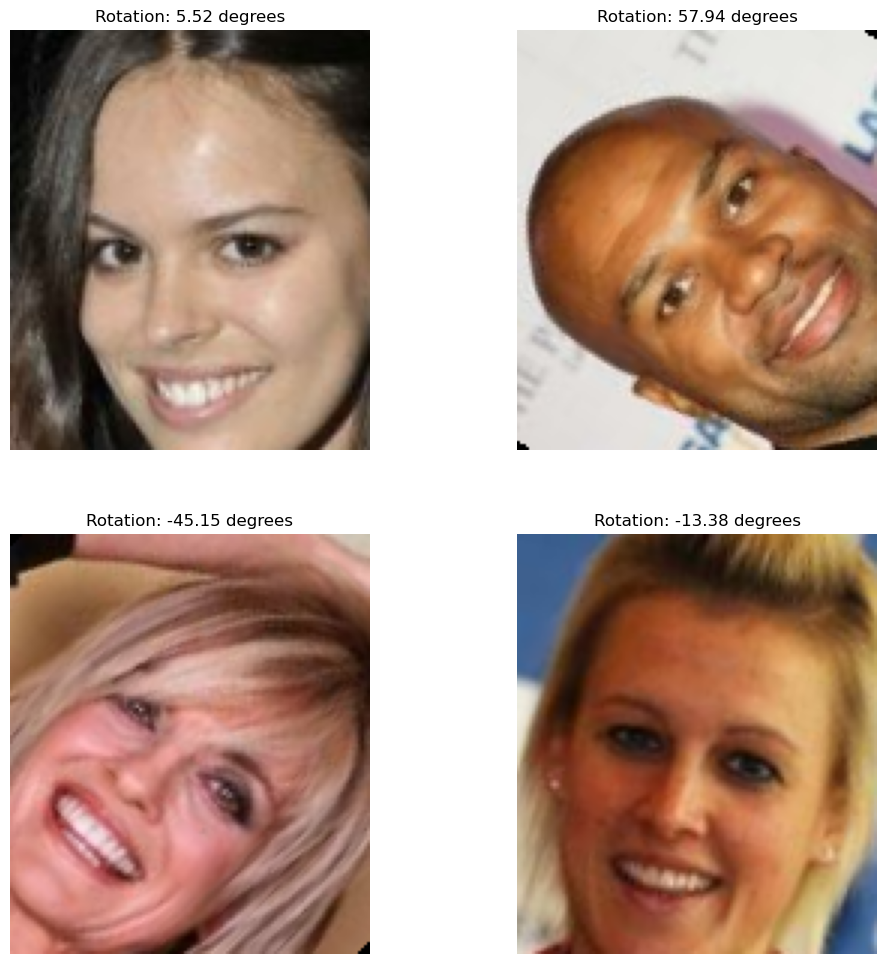

In [17]:
# make plotting of rotated images function
def plot_rotated_images(dataset, num_images=4):
    plt.figure(figsize=(12, 12))
    for i, (image, label) in enumerate(dataset.take(num_images)):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow((image.numpy() * 255).astype("uint8"))
        plt.title(f"Rotation: {label.numpy():.2f} degrees")
        plt.axis("off")
    plt.show()

plot_rotated_images(train_rot_ds, num_images=4)


<a id="q22"></a>


<!-- BEGIN QUESTION -->

<div class='exercise'>
<b>2.2 Building and training your CNN</b>
<hr>
<a id="q221"></a>
<b>Q2.2.1 Compiling your model.</b>
    
Construct a model with multiple Conv layers and any other layers you think would help. Be certain to print your model summary as always. Feel free to experiment with architectures and number of parameters if you wish to get better performance or better training speed. You certainly don't need more than a few million parameters; we have been able to do it with substantially fewer. 
    
**Note:** Again, it is fine to attempt your own implementation of a well-known architecture, but you may not load any pre-constructed models. The network must be built layer-by-layer from your own code.
    </div>

In [18]:
# with help from lab 7
def inception_block(input_tensor, filters):
    # Branch 1
    branch1 = Conv2D(filters[0], (1,1), activation='relu')(input_tensor)

    # Branch 2
    branch2 = Conv2D(filters[1], (1,1), activation='relu')(input_tensor)
    branch2 = Conv2D(filters[2], (3,3), padding='same', activation='relu')(branch2)

    # Branch 3
    branch3 = Conv2D(filters[3], (1,1), activation='relu')(input_tensor)
    branch3 = Conv2D(filters[4], (5,5), padding='same', activation='relu')(branch3)

    # Branch 4
    branch4 = MaxPooling2D((3,3), strides=(1,1), padding='same')(input_tensor)
    branch4 = Conv2D(filters[5], (1,1), activation='relu')(branch4)

    # Concatenate branches
    output_tensor = Concatenate(axis=-1)([branch1, branch2, branch3, branch4])

    return output_tensor

In [19]:
# with help from lab 7
def auxiliary_block(input_tensor, aux_name):
    X = AveragePooling2D(pool_size = (5,5), strides = (3,3), padding='same')(input_tensor)
    X = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X)
    X = Flatten()(X)
    X = Dense(1024, activation = 'relu')(X)
    X = Dropout(0.7)(X)
    output_tensor = Dense(10, activation = 'softmax', name = aux_name)(X)

    return output_tensor

In [20]:
# with help from lab 7
def model_2(input_shape):
    inp = Input(shape=input_shape)

    X = Conv2D(64, (7,7), strides=(2,2), padding='same', activation='relu')(inp)
    X = MaxPooling2D((3,3), strides=(2,2), padding='same')(X)
    X = Conv2D(64, (1,1), activation='relu')(X)
    X = Conv2D(64, (3,3), padding='same', activation='relu')(X)
    X = MaxPooling2D((3,3), strides=(2,2), padding='same')(X)

    # First Inception blocks (x2)
    X = inception_block(X, [64, 96, 128, 16, 32, 32])
    X = inception_block(X, [128, 128, 192, 32, 96, 64])
    X = MaxPooling2D((3,3), strides=(2,2), padding='same')(X)

    # Second Inception blocks (x5)
    X = inception_block(X, [192, 96, 208, 16, 48, 64])
    X = inception_block(X, [160, 112, 224, 24, 64, 64])
    X1 = auxiliary_block(X, aux_name = 'aux_output1') # First Auxiliary block

    X = inception_block(X, [128, 128, 256, 24, 64, 64])
    X = inception_block(X, [112, 144, 288, 32, 64, 64])
    X = inception_block(X, [256, 160, 320, 32, 128, 128])
    X2 = auxiliary_block(X, aux_name = 'aux_output2') # Second Auxiliary block

    # Third Inception blocks (x2)
    X = MaxPooling2D((3,3), strides=(2,2), padding='same')(X)
    X = inception_block(X, [256, 160, 320, 32, 128, 128])
    X = inception_block(X, [384, 192, 384, 48, 128, 128])
    X = GlobalAveragePooling2D()(X)
    X = Dense(1, activation='linear', name='main_output')(X)
    model = Model(inputs=inp, outputs=[X, X1, X2])

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='mse',  
        metrics=['mae'] # mean absolute error
    )

    return model

In [21]:
# print the summary of the model
input_shape = (140, 120, 3)
model = model_2(input_shape)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 140, 120, 3)]        0         []                            
                                                                                                  
 conv2d_70 (Conv2D)          (None, 70, 60, 64)           9472      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d_28 (MaxPooli  (None, 35, 30, 64)           0         ['conv2d_70[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_71 (Conv2D)          (None, 35, 30, 64)           4160      ['max_pooling2d_28[0][0]']

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.2.2 Training your model</b>

<a id="q222"></a>

Train your model. Please note that the `model.fit()` argument syntax is a little different when working with Datasets instead of numpy arrays; take a look at the [tf.keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) documentation. Be sure to also pass the test data as validation data. When passing `train_rot_ds` to `.fit()`, you will find it useful to use pipelines to [batch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) the data. You can also experiment with [prefetching](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) batches/elements from the dataset, which may allow you to speed up iterations by a few percent. Finally, while dry-running and prototyping your model, you may find it useful to [take](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take) a subset of the data to speed up experimentation. However, your final model MUST be trained on all the available training data! You should achieve test MSEs of less than 9, corresponding roughly to $\pm 3^\circ$ accuracy in predicting the rotations on the test set. This can be achieved in just 2-3 epochs, though you are free to train as long as you want.
    </div>

In [22]:
# to save the penguins
model_file = "model/q2_model.h5"

# batching epicness (outside for easier loading)
batch_size = 64
train_ds = train_rot_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = test_rot_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# load weights if they already exist
if os.path.exists(model_file):
    print("Loading saved model from", model_file)
    model = load_model(model_file)

# train this beefy model
else:
    print("No saved model found. Creating and training a new model.")
    # create your model using model function from earlier
    model = model_2(input_shape)
    
    history = model.fit(train_ds, 
                        validation_data=test_ds, 
                        epochs=3, 
                        verbose=1)

    # save the trained model
    model.save(model_file)
    print("Model saved to", model_file)

# print the test loss
results = model.evaluate(test_ds, verbose=1, return_dict=True)
print("Main MSE:", results['main_output_loss'])
print("Main MAE:", results['main_output_mae'])

Loading saved model from model/q2_model.h5
312/312 [==============================] - 21s 64ms/step - loss: 2401.3694 - main_output_loss: 4.1592 - aux_output1_loss: 1198.6052 - aux_output2_loss: 1198.6052 - main_output_mae: 1.3902 - aux_output1_mae: 29.9672 - aux_output2_mae: 29.9672
Main MSE: 4.1591668128967285
Main MAE: 1.3901666402816772


<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.2.3 Saving and loading your weights</b>

<a id="q223"></a>

Save your model weights to the path `model/your_model_name` where `your_model_name` is whatever filename prefix you want. Then reload your weights from that same path.
    </div>

In [23]:
# I already saved the weights from the previous part, but here it is again
if os.path.exists(model_file): # load the weights from path
    model = load_model(model_file)
    print(f"Model weights loaded from {model_file}")
else:
    model.save(model_file)
    print(f"Model weights saved to {model_file}")

Model weights loaded from model/q2_model.h5


<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.2.4 Evaluating your model</b>

<a id="q224"></a>

Create a subplots grid with 4 rows and 3 columns. Each row will be a separate image from the test set (of your choice) and each column will consist of: Original Image, Predicted Straightened Image, Target Straightened Image. The title of the latter two should be the predicted rotation and the actual rotation. For example, a row should look something like the image shown below. This can be achieved using the provided function `rot_resize` to correct for the rotation predicted by your network.

![straightened face](data/straightened.png)
    
**Hint:** Your network expects its input to have an explicit 'batch' dimension (the 1st dimension). If you use `take()` to get one image from your dataset, you will need to add this extra batch dimension to it in order to pass it to `predict()`. There are several ways to do this. You can check out [this SO post](https://stackoverflow.com/questions/43017017/keras-model-predict-for-a-single-image) for some ideas.

In [24]:
def rot_resize(img, deg):
    """Rotate image by specified degrees and resize to 140x120."""
    # Ensure the input is a numpy array
    if isinstance(img, tf.Tensor):
        img = img.numpy()
    
    # Apply rotation using SciPy's ndimage
    rotimg = ndimage.rotate(img, deg, reshape=False, order=3)
    
    # Clip values to valid range
    rotimg = np.clip(rotimg, 0., 1.)
    
    # Resize using TensorFlow's crop_and_resize
    rotimg = tf.convert_to_tensor(rotimg, dtype=tf.float32)
    rotimg = tf.image.resize_with_crop_or_pad(rotimg, 140, 120)
    
    # Convert back to numpy for matplotlib
    return rotimg.numpy()

/tmp/ipykernel_6859/1068498705.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_angle = float(model.predict(image_batch, verbose=0)[0][0])


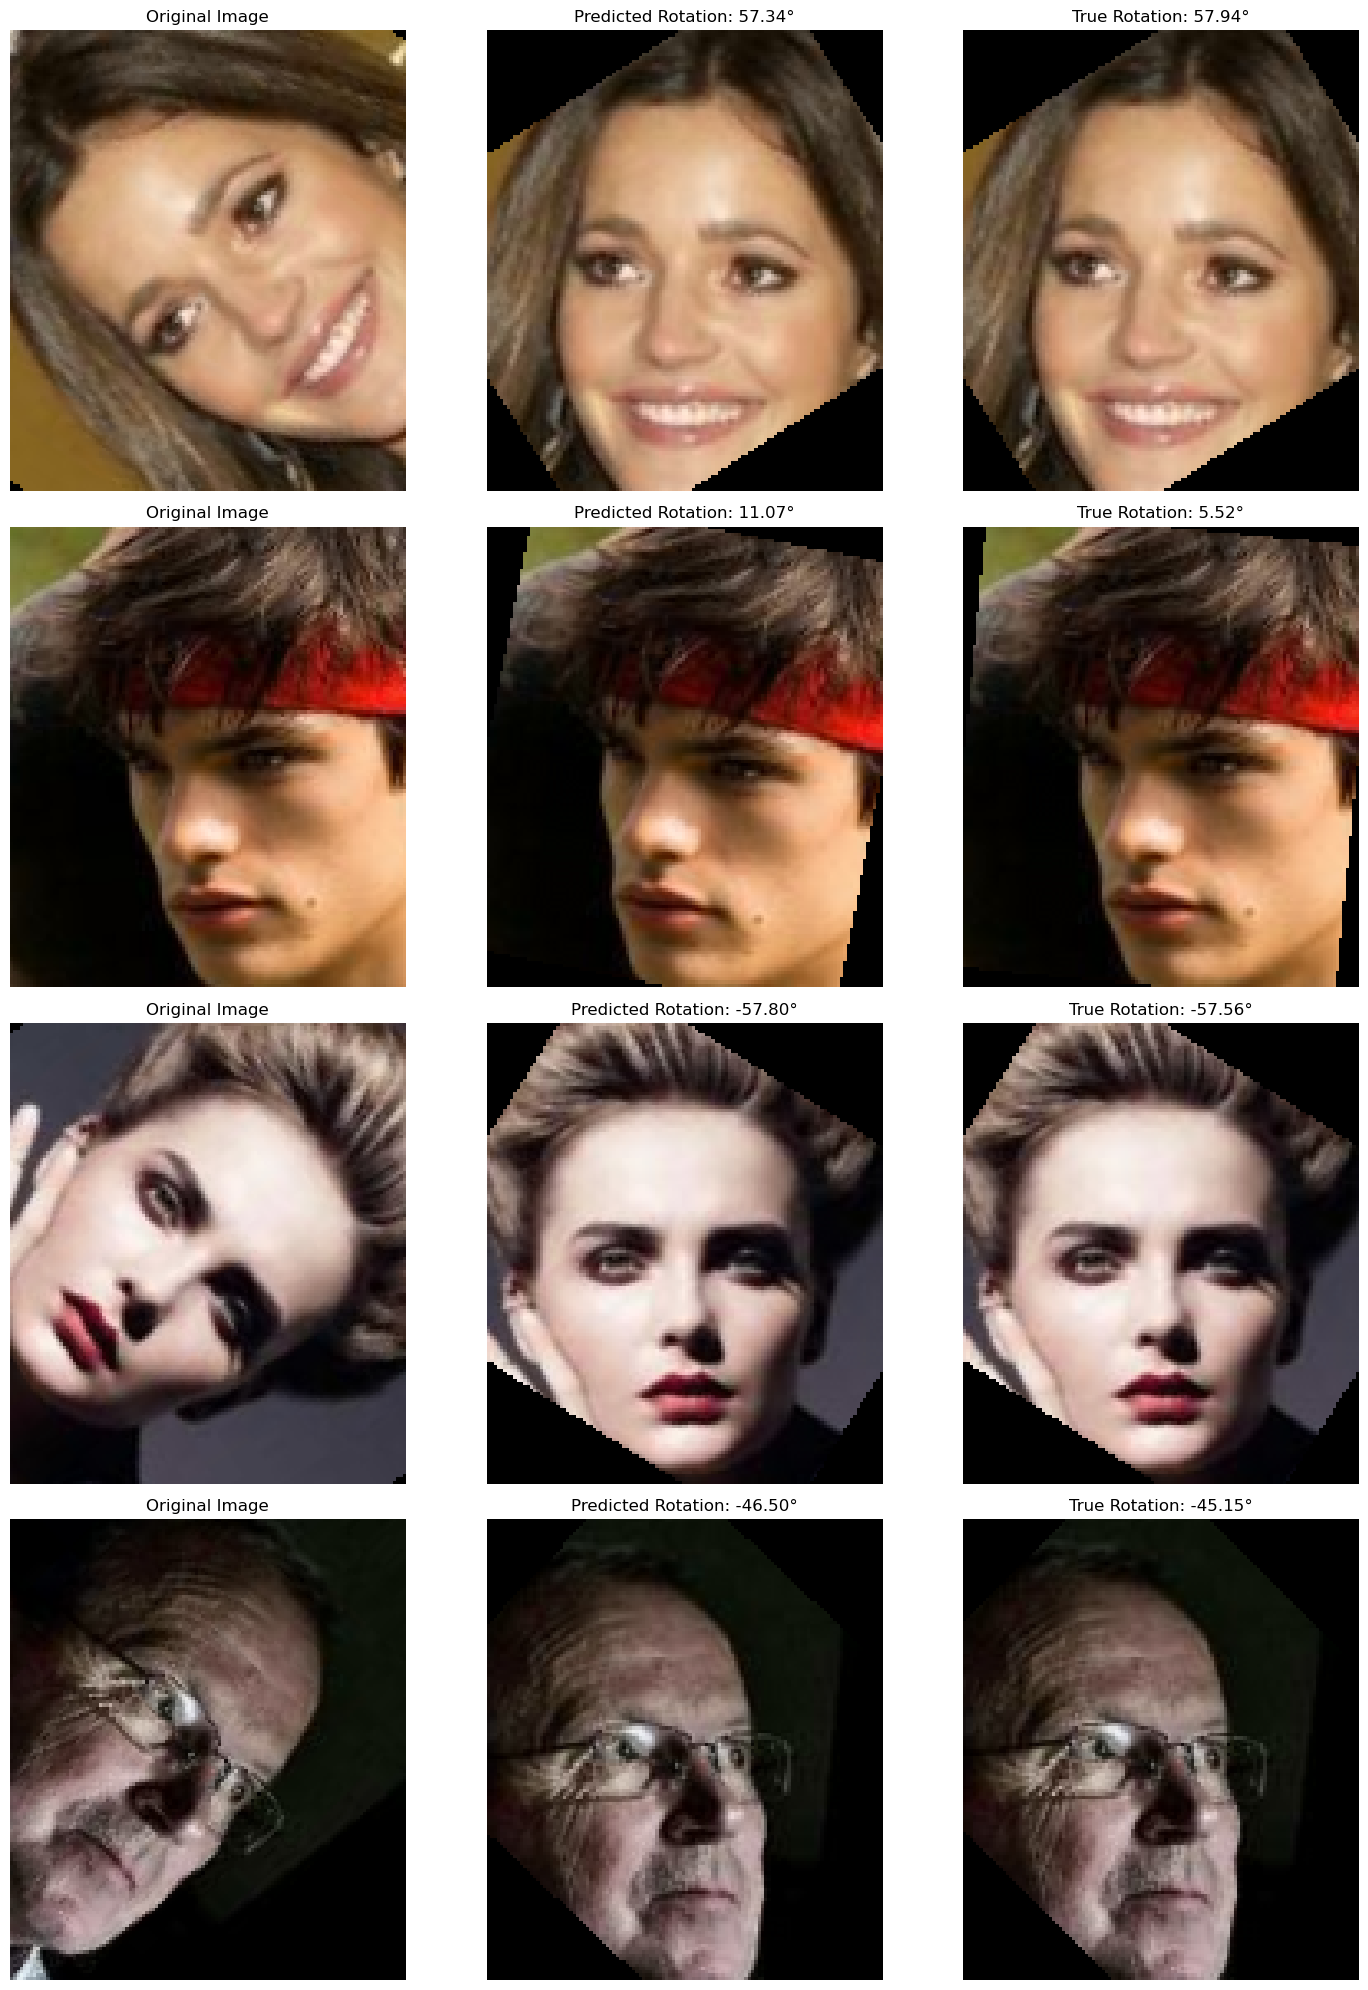

In [25]:
# 4 rows and 3 columns
plt.figure(figsize=(15, 20))

# get 4 images from the test dataset
for idx, (image, true_angle) in enumerate(test_rot_ds.take(4)):
    # add batch dimension
    image_batch = image[tf.newaxis, ...]
    
    # predict rotation angle
    pred_angle = float(model.predict(image_batch, verbose=0)[0][0])
    
    # straighten images using rot_resize
    pred_straight = rot_resize(image, -pred_angle)
    true_straight = rot_resize(image, -true_angle)
    
    # plot original image
    plt.subplot(4, 3, idx*3 + 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')
    
    # plot predicted straightened image
    plt.subplot(4, 3, idx*3 + 2)
    plt.imshow(pred_straight)
    plt.title(f'Predicted Rotation: {pred_angle:.2f}°')
    plt.axis('off')
    
    # Plot true straightened image
    plt.subplot(4, 3, idx*3 + 3)
    plt.imshow(true_straight)
    plt.title(f'True Rotation: {true_angle:.2f}°')
    plt.axis('off')

plt.tight_layout()
plt.show()

<!-- BEGIN QUESTION -->

<div class='exercise'>
<a id="q23"></a>
<b>2.3 Further Analysis</b>
<hr>
<b>Q2.3.1 Correct an image of your choosing</b>

<a id="q231"></a>

Find an image or image(s) (not from the provided test/training sets), or make your own; it does not necessarily have to be a human face. You may rotate it yourself up to $\pm60^\circ$, or the face can already be naturally rotated. Resize and crop the image to 140px by 120px, load it here, and normalize it to [0.,1.], and use your network to correct it.

![Confused Chris](data/chrisprattcorrection.png)
    
**Note:** Please do *not* upload your custom image as a separate file with your notebook submission. It is sufficient to display your results in the cell output.
    </div>

1/1 [==============================] - 0s 20ms/step


/tmp/ipykernel_6859/3823184787.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_rotation = float(model.predict(image_array)[0][0])


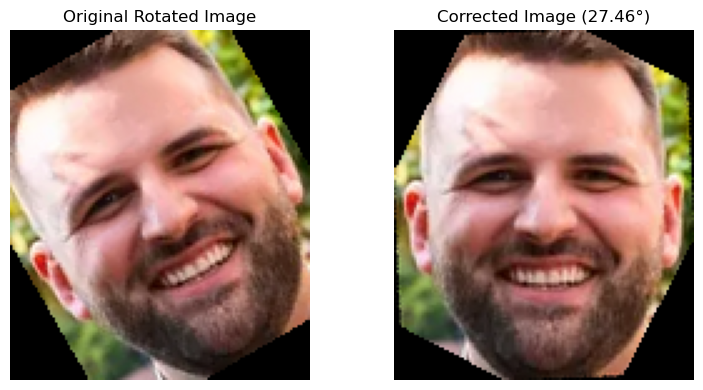

In [26]:
# Load the image and convert to RGB
image_path = "data/example.png"
image = Image.open(image_path).convert('RGB')

# prepare and normalize the image to be fed into model
image_tensor = tf.convert_to_tensor(np.array(image)).numpy()
normalized_image = image_tensor / 255.0

# rotate the image by a determined amount
angle = 30 
rotated_image = ndimage.rotate(normalized_image, angle, reshape=False, order=3)
rotated_image = np.clip(rotated_image, 0., 1.)

# let model predict rotation
image_array = np.expand_dims(rotated_image, axis=0)
predicted_rotation = float(model.predict(image_array)[0][0])
corrected_image = rot_resize(rotated_image, -predicted_rotation)

# plot the original rotated image and the corrected image
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(rotated_image)
axes[0].set_title("Original Rotated Image")
axes[0].axis("off")

axes[1].imshow(corrected_image)
axes[1].set_title(f"Corrected Image ({predicted_rotation:.2f}°)")
axes[1].axis("off")

plt.tight_layout()
plt.show()


<a id="part3"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

# PART 3: Image Segmentation
<a id="part3intro"></a>
## Overview

[Return to contents](#contents)

In this section, we will use the Oxford-IIIT Pet dataset to design a model for an image segmentation task.

[Semantic image segmentation](https://arxiv.org/abs/2302.06378) is a computer vision application where we assign a semantically meaningful label, or class, to every pixel in the image. For example, a camera on a self-driving car would segment the imagery around it into semantic labels such as "Road", "Person", "Bike", etc.

Our  dataset contains images of various pet breeds along with their corresponding segmentation masks. Each raw image is 500x403 with three RGB channels, while the corresponding mask is of the same size but contains only a single channel, indicating the pixel class.

For simplicity, we resize both the images and masks to 64x64 to speed up training.
We have also have provided all the necessary preprocessing code for you as well as some functions for visualization.

In [27]:
# Load the dataset with tensorflow-datasets
ds_source = tfds.load(
    'oxford_iiit_pet',
    split='test', # train set has corrupted images :(
    as_supervised=False, # we done need the dog breed labels
    download=True,
)

# Check the first example
example = next(iter(ds_source))
print(example.keys())
print(f"The raw image shape is: {example['image'].shape}")
print(f"The raw segmentation mask shape is: {example['segmentation_mask'].shape}")

dict_keys(['file_name', 'image', 'label', 'segmentation_mask', 'species'])
The raw image shape is: (500, 403, 3)
The raw segmentation mask shape is: (500, 403, 1)


In [28]:
def preprocess(sample, reduce_class=False, resize_dim=64):
    """
    Complete preprocessing function that:
    1. Resizes image and mask to (resize_dim, resize_dim)
    2. Normalizes image to [0,1] range
    3. Remaps class indices to be more intuitive
    4. Optionally reduces to 2 classes
    5. Clips pixel values in case of corrupted jpegs
    6. Returns (image, mask) tuple
    """
    image = sample['image']
    mask = sample['segmentation_mask']

    # Resize using bilinear interpolation for image and nearest neighbor for mask
    image = tf.image.resize(image, [resize_dim, resize_dim], method='bilinear')
    mask = tf.image.resize(mask, [resize_dim, resize_dim], method='nearest')

    # Normalize the image: convert from [0, 255] to [0, 1]
    image = tf.cast(image, tf.float32) / 255.0

    # Convert mask values from 1-indexed to 0-indexed
    mask = tf.cast(mask, tf.int32) - 1

    # Remap classes to be more intuitive
    # Current: 0-pet border, 1-background, 2-pet interior
    # Desired: 0-background, 1-border, 2-center
    new_mask = tf.zeros_like(mask)
    new_mask = tf.where(mask == 1, 0, new_mask)  # Map old background (1) to new background (0)
    new_mask = tf.where(mask == 0, 1, new_mask)  # Map old border (0) to new border (1) 
    new_mask = tf.where(mask == 2, 2, new_mask)  # Keep center as class 2
    
    # Reduce problem difficulty if requested
    if reduce_class:
        # Combine border and center into a single "pet" class
        # Now we have: 0-background, 1-pet (both border and center)
        new_mask = tf.where(new_mask > 0, 1, 0)

    # Handle corrupt JPEG data by ensuring valid values
    image = tf.clip_by_value(image, 0.0, 1.0)

    # Always return (image, mask) tuple
    return image, new_mask

In [29]:
# Helper functions for visualization
def visualize_image_and_mask(dataset, num_examples=5):
    """Visualizes image and segmentation mask pairs from the dataset."""
    for i, (image, mask) in enumerate(dataset.take(num_examples)):
        # Convert to numpy arrays
        image = image.numpy()
        mask = mask.numpy().squeeze()
        
        # Convert normalized image to uint8 for display
        if image.dtype == np.float32 and image.max() <= 1.0:
            display_image = (image * 255.0).astype('uint8')
        else:
            display_image = image.astype('uint8')
        
        mask = mask.astype(int)
        
        # Visualize
        plt.figure(figsize=(8, 4))

        # Plot the image
        plt.subplot(1, 2, 1)
        plt.imshow(display_image)
        plt.title("Image")
        plt.axis("off")

        # Plot the segmentation mask
        plt.subplot(1, 2, 2)
        cmap_choice = 'gray' if mask.max() <= 1 else 'viridis'
        plt.imshow(mask, cmap=cmap_choice, vmin=0, vmax=mask.max())
        plt.title("Segmentation Mask")
        plt.axis("off")

def visualize_predictions(dataset, model, num_examples=5, show_iou=False):
    """
    Visualizes predictions from a segmentation model alongside ground truth.
    
    Args:
        dataset: TensorFlow dataset containing images and masks
        model: Trained segmentation model
        num_examples: Number of examples to visualize
        show_iou: Whether to compute and display IoU metrics (default: False)
    """
    shuffled_dataset = dataset.shuffle(buffer_size=200)
    
    for i, (images, masks) in enumerate(shuffled_dataset.take(num_examples)):
        # Check if the dataset is batched
        if len(images.shape) == 4:  # Batched data
            batch_size = images.shape[0]
            random_index = random.randint(0, batch_size - 1)
            image_for_pred = images[random_index]
            mask = masks[random_index]
        else:  # Unbatched data
            image_for_pred = images
            mask = masks
            
        # Convert to numpy and prepare for display
        display_image = (image_for_pred * 255.0).numpy().astype('uint8')
        
        # Predict the segmentation mask
        with tf.device('/CPU:0'):
            pred_mask = model.predict(image_for_pred[tf.newaxis, ...], verbose=0)
        pred_mask = tf.argmax(pred_mask, axis=-1)[0]
        
        # Calculate metrics for this example
        true_mask = mask.numpy().squeeze()
        pred_mask_np = pred_mask.numpy().squeeze()
        
        # Calculate pixel-wise accuracy
        accuracy = (true_mask == pred_mask_np).mean()
        
        # Visualize
        plt.figure(figsize=(12, 4))
        
        # Plot the input image
        plt.subplot(1, 3, 1)
        plt.imshow(display_image)
        plt.title("Input Image")
        plt.axis("off")
        
        # Plot the ground truth mask
        plt.subplot(1, 3, 2)
        cmap_choice = 'gray' if true_mask.max() <= 1 else 'viridis'
        plt.imshow(true_mask, cmap=cmap_choice, vmin=0, vmax=true_mask.max())
        plt.title("Ground Truth Mask")
        plt.axis("off")
        
        # Plot the predicted mask with metrics in the title
        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask_np, cmap=cmap_choice, vmin=0, vmax=true_mask.max())
        
        if show_iou:
            # Calculate IoU for this example
            intersection = np.logical_and(true_mask, pred_mask_np).sum()
            union = np.logical_or(true_mask, pred_mask_np).sum()
            iou = intersection / union if union > 0 else 1.0
            plt.title(f"Predicted Mask\nAcc: {accuracy:.2%} | IoU: {iou:.2%}")
        else:
            plt.title(f"Predicted Mask\nAcc: {accuracy:.2%}")
            
        plt.axis("off")
        plt.tight_layout()

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q3.1 Deep CNN for Image Segmentation</b>

<a id="q31"></a>

Here you'll design a segmentation model that utilizes convolutional layers and skip connections. The model should perform a binary classification task, predicting the class for each pixel which is compared to the ground truth segmentation mask. 

Minimum Requirements:
- A reasonably deep CNN architecture (you should be able to get above 80% validation accuracy with only 90 seconds of training)
- Accepts an input size of 64 × 64 × 3 and performs pixel-level binary classification.
- At least four skip connections placed appropriately.
- Compile the model with an appropriate loss function and include accuracy as an evaluation metric.
- Set the model name to `model_deepcnn`
- Assign the result of `model_deepcnn.fit()` to a variable named `history_model_deepcnn`.

We've created a train and validation set for you below.

**HINT:** Typically, for binary classification we utilize the sigmoid activation function with a single output unit. That can be an appropriate method for this task as well, where we have a single output filter. However, considering a 2-class classification with a softmax activation function and two output units will also work. You may find a difference in performance between the two methods. Be sure you are selecting the appropriate loss for your choice.
    </div>

# Motivation behind the model

I saw the proceeding question and figured that I also wanted to use a U-Net architecture for my deep CNN model. I learned that U-Net has encoder-decoder architecture, so I asked ChatGPT to explain why, and this is what it told me:

"The key idea is to extract high-level semantic features while still preserving the spatial detail needed for accurate pixel-level predictions. Here’s why this design is used:

- **Feature Extraction and Compression:**  
  The encoder part of the network gradually reduces the spatial dimensions while increasing the number of feature channels. This compression helps the network focus on the most important high-level features (similar to how an autoencoder compresses input data).

- **Reconstruction of Spatial Details:**  
  The decoder upsamples the compressed features back to the original resolution. This is essential for segmentation, where you need to assign a class label to every pixel. Without upsampling, the high-level features wouldn’t align with the original image’s spatial dimensions.

- **Skip Connections:**  
  The skip connections from the encoder to the decoder help recover fine-grained spatial details that might be lost during downsampling. They enable the decoder to combine both the high-level, abstract information (from deeper layers) and the low-level, detailed information (from shallower layers).

So, while we’re borrowing ideas from autoencoders, the goal here is to achieve pixel-level classification by combining the best of both feature abstraction (via the encoder) and detail preservation (via the decoder with skip connections)."

In [30]:
# Create processed binary segmentation dataset
ds_2c = ds_source.map(lambda sample: preprocess(sample, reduce_class=True),
                               num_parallel_calls=tf.data.AUTOTUNE)
# 85/15 train-test split
ds_2c_train, ds_2c_test = tf.keras.utils.split_dataset(ds_2c, left_size=0.85)
# Reserve 20% of train as validation
ds_2c_train, ds_2c_val = tf.keras.utils.split_dataset(ds_2c, left_size=0.80)

# Dataset sizes
print("Train:", ds_2c_train.cardinality().numpy())
print("Validation:", ds_2c_val.cardinality().numpy())
print("Test:", ds_2c_test.cardinality().numpy())

Train: 2935
Validation: 734
Test: 550


Here are some of the images and their corresponding segmentation masks. The segmentation mask categorizes each pixel into two classes: "background" or "pet".

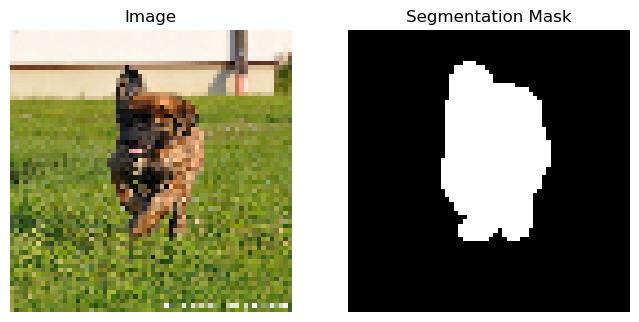

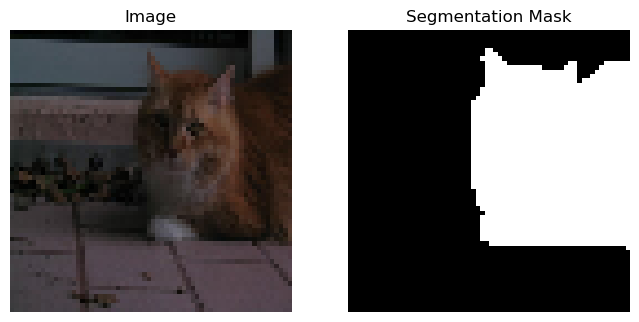

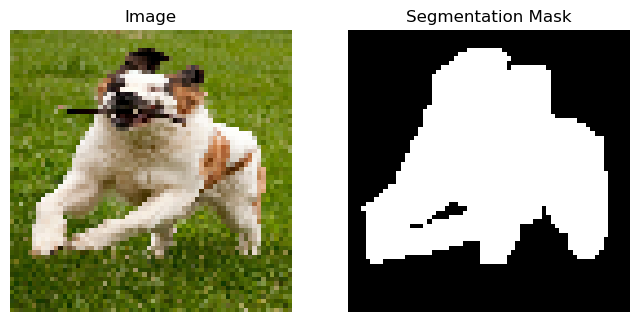

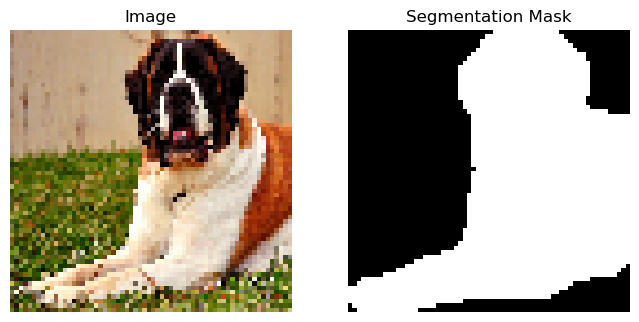

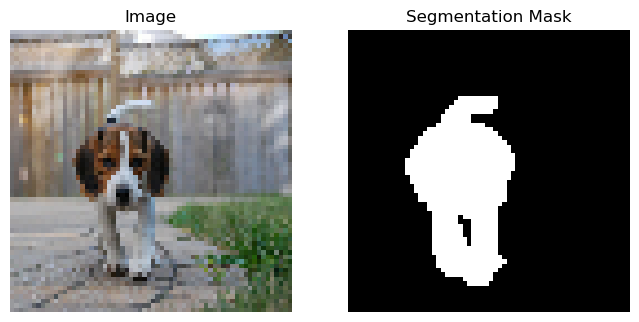

In [31]:
# Visualize 5 examples from the training split
visualize_image_and_mask(ds_2c_train)

In [32]:
# Creating a Residual Block
def Residual(X, num_channels, strides=1, use_1x1conv=False):
    A = Conv2D(num_channels, kernel_size=3, padding='same', strides=strides)(X)
    A = BatchNormalization()(A)
    A = Activation('relu')(A)
    A = Conv2D(num_channels, kernel_size=3, padding='same')(A)
    A = BatchNormalization()(A)
    if use_1x1conv:
        X = Conv2D(num_channels, kernel_size=1, strides=strides, padding='same')(X)
    # Internal skip connection of the residual block
    A = Add()([A, X])
    A = Activation('relu')(A)
    return A

In [33]:
# from Ed, IoU is a good metric to use
def iou_metric(y_true, y_pred): # MeanIoU wasn't working
    # Convert predictions to binary (0 or 1)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    
    # Calculate the intersection and union
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3]) - intersection
    
    # Compute IoU, adding a small epsilon to avoid division by zero
    iou = tf.reduce_mean((intersection + 1e-7) / (union + 1e-7))
    return iou

# build model function
def deep_cnn_model(input_shape=(64, 64, 3), num_classes=2):
    inputs = Input(shape=input_shape)
    
    # implementing the ResNet start
    x1 = Conv2D(64, kernel_size=3, padding='same')(inputs)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)

    # residual block 1: no downsampling; output resolution 64x64
    r1 = Residual(x1, 64)  # (Skip Connection #1)

    # downsample to half resolution (from 64x64 -> 32x32)
    p1 = MaxPooling2D(pool_size=2)(r1)
    
    # residual block 2: resolution 32x32
    r2 = Residual(p1, 128, use_1x1conv=True, strides=1)  # (Skip Connection #2)
    
    # downsample to half resolution (from 32x32 -> 16x16)
    p2 = MaxPooling2D(pool_size=2)(r2)
    
    # residual block 3: resolution 16x16
    r3 = Residual(p2, 256, use_1x1conv=True, strides=1)  # (Skip Connection #3)
    
    # downsample to half resolution (from 16x16 -> 8x8)
    p3 = MaxPooling2D(pool_size=2)(r3)
    
    # bottleneck: resolution is unchanged
    bn = Residual(p3, 512, use_1x1conv=True, strides=1)  
    
    # upsample and add skip connection from r3
    u1 = UpSampling2D(size=2)(bn)  # 8x8 -> 16x16
    concat1 = Concatenate()([u1, r3])  # U-Net style skip connection (Skip Connection #4)
    d1 = Residual(concat1, 256, use_1x1conv=True, strides=1)
    
    # upsample and add skip connection from r2
    u2 = UpSampling2D(size=2)(d1)  # 16x16 -> 32x32
    concat2 = Concatenate()([u2, r2])  # U-Net style skip connection (Skip Connection #5)
    d2 = Residual(concat2, 128, use_1x1conv=True, strides=1)
    
    # upsample and add skip connection from r1
    u3 = UpSampling2D(size=2)(d2)  # 32x32 -> 64x64
    concat3 = Concatenate()([u3, r1])  # U-Net style skip connection (Skip Connection #6)
    d3 = Residual(concat3, 64, use_1x1conv=True, strides=1)
    
    # output layer: use softmax activation to get per-pixel class probabilities
    outputs = Conv2D(num_classes, kernel_size=1, activation='softmax', padding='same')(d3)
    
    model = Model(inputs, outputs)
    return model

# create & compile model_deepcnn
model_deepcnn = deep_cnn_model()
model_deepcnn.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',  # Suitable for integer masks with 2 classes
    metrics=['accuracy', iou_metric]  # use custom iou_metric because MeanIoU doesn't work
)
model_deepcnn.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_129 (Conv2D)         (None, 64, 64, 64)           1792      ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 64, 64, 64)           256       ['conv2d_129[0][0]']          
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 64, 64, 64)           0         ['batch_normalization[0]

In [34]:
# train and validation dataset
train_dataset = ds_2c_train.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = ds_2c_val.batch(32).prefetch(tf.data.AUTOTUNE)

# fit model
history_model_deepcnn = model_deepcnn.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,  
    verbose=1
)

Epoch 1/20
92/92 [==============================] - 26s 155ms/step - loss: 0.4489 - accuracy: 0.7954 - iou_metric: 0.2859 - val_loss: 0.9606 - val_accuracy: 0.5850 - val_iou_metric: 0.2815
Epoch 2/20
92/92 [==============================] - 6s 65ms/step - loss: 0.3371 - accuracy: 0.8523 - iou_metric: 0.2859 - val_loss: 0.7486 - val_accuracy: 0.6624 - val_iou_metric: 0.2815
Epoch 3/20
92/92 [==============================] - 6s 65ms/step - loss: 0.2783 - accuracy: 0.8806 - iou_metric: 0.2859 - val_loss: 0.5512 - val_accuracy: 0.7391 - val_iou_metric: 0.2815
Epoch 4/20
92/92 [==============================] - 6s 65ms/step - loss: 0.2230 - accuracy: 0.9061 - iou_metric: 0.2859 - val_loss: 0.5331 - val_accuracy: 0.7600 - val_iou_metric: 0.2815
Epoch 5/20
92/92 [==============================] - 6s 66ms/step - loss: 0.1749 - accuracy: 0.9279 - iou_metric: 0.2859 - val_loss: 0.5640 - val_accuracy: 0.7752 - val_iou_metric: 0.2815
Epoch 6/20
92/92 [==============================] - 6s 66ms/ste

Run the cell below to visualize your loss and accuracy.

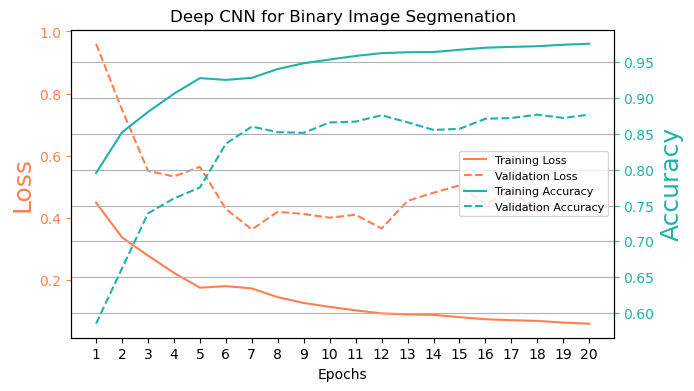

In [35]:
def plot_training_history(model_history_object, model_name=''):
    # Extract the training history dictionary
    hist_dict = model_history_object.history
    # Plot
    plt.figure(figsize=(7, 4))
    loss_color = 'coral'
    # Plot Loss on the primary y-axis
    loss_plot, = plt.plot(hist_dict['loss'],
                          label='Training Loss', color=loss_color)
    val_loss_plot, = plt.plot(hist_dict['val_loss'],
                              label='Validation Loss', color=loss_color, linestyle='--')
    
    # Label for the primary y-axis (Loss)
    plt.ylabel('Loss', color=loss_color, fontsize=18)
    plt.gca().tick_params(axis='y', colors=loss_color)
    ticks = range(0, len(hist_dict['loss'])+1)
    plt.xticks(ticks=ticks, labels=[x+1 for x in ticks])
    plt.xlabel('Epochs')  # X-axis label
    plt.title(model_name)
    
    # Create a secondary y-axis for Accuracy
    acc_color = 'lightseagreen'
    ax2 = plt.gca().twinx()
    train_acc = hist_dict.get('accuracy', hist_dict.get('acc'))
    val_acc = hist_dict.get('val_accuracy', hist_dict.get('val_acc'))
    accuracy_plot, = ax2.plot(train_acc,
                              label='Training Accuracy', color=acc_color)
    val_accuracy_plot, = ax2.plot(val_acc,
                                  label='Validation Accuracy', color=acc_color, linestyle='--')
    ax2.set_ylabel('Accuracy', color=acc_color, fontsize=18)
    ax2.tick_params(axis='y', colors=acc_color)
    
    plt.grid()
    lines = [loss_plot, val_loss_plot, accuracy_plot, val_accuracy_plot]
    labels = [line.get_label() for line in lines]
    plt.legend(lines, labels, loc='right', fontsize=8);

plot_training_history(history_model_deepcnn, model_name="Deep CNN for Binary Image Segmenation")

Run the cell below, and you will see your segmentation result. You can run the cell multiple times to see different result sets.

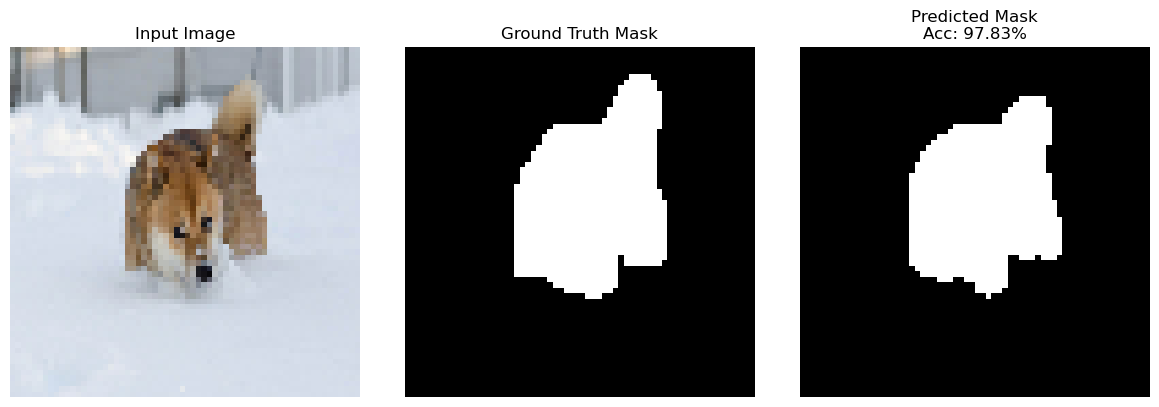

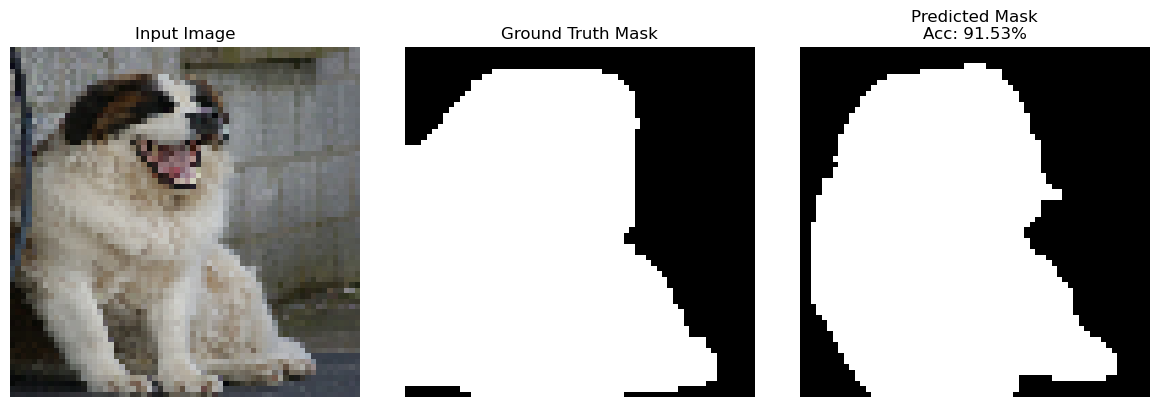

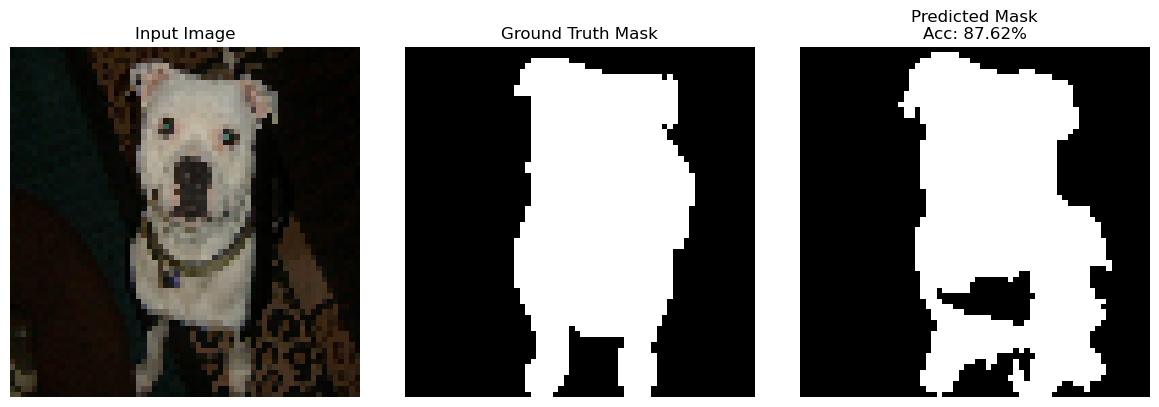

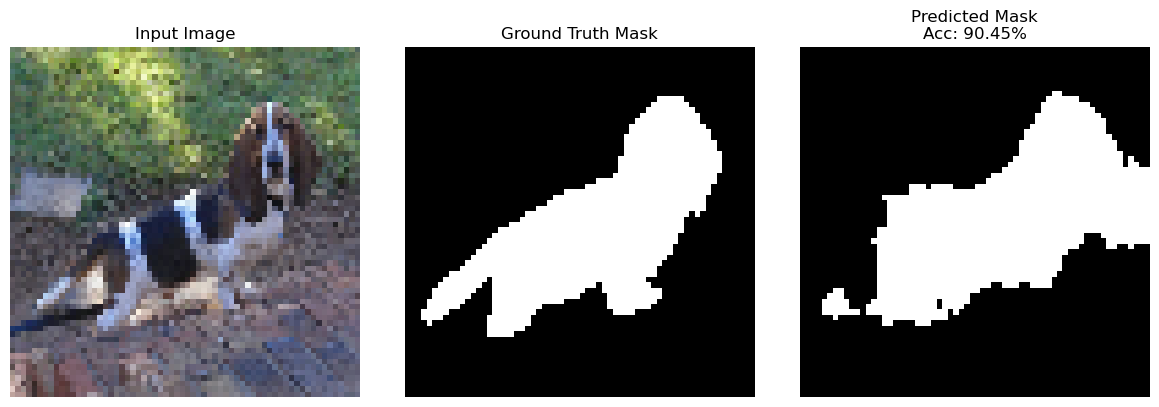

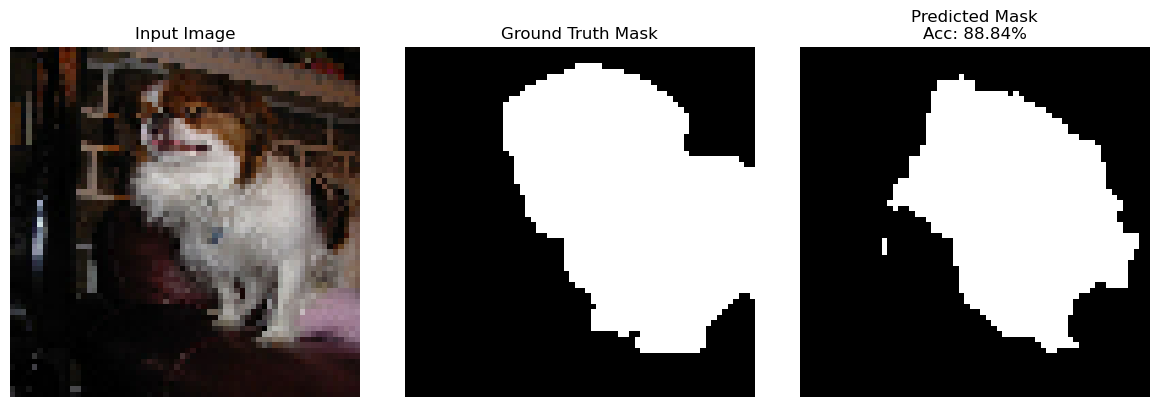

In [36]:
visualize_predictions(ds_2c_test, model_deepcnn)

<div class='exercise'><b>[209] Q3.2 U-Net for 3-Class Image Segmentation</b>

<a id="q32"></a>  
This question is required for 209 students but optional for others. Extra credit will not be given if attempted by non-209 students, but you may learn something new! :) 

In the previous model, the predictions were limited because we had to maintain the same dimensions throughout. This restricted the ability to capture different levels of detail. To address this, we introduce a new architecture: **U-Net**.  

U-Net is a segmentation model originally designed for biomedical image segmentation. It follows an encoder-decoder structure with skip connections, allowing it to capture both fine details and high-level semantic features. This structure makes U-Net highly effective for pixel-wise classification. To learn more, please see:

- [ED Slides and Notebook](https://edstem.org/us/courses/74185/lessons/133380/slides/750646)
- **Reference Paper:** [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597)  

You will build a U-Net model that takes a 64 × 64 × 3 image as input and classifies each pixel into one of three categories:  
- Background  
- Border-of-Pet
- Pet  

In the previous model, accuracy was used as a metric. However, for segmentation tasks, accuracy can be misleading. A model predicting all pixels as "background" could still appear accurate if there is a data imbalance. Instead, consider exploring alternative metrics. 
Refer to the links above for different approaches.  

Minimum Requirements: \
To complete this task successfully, your model must:  
- Follow an encoder-decoder architecture.  
- Accept 64 × 64 × 3 input images and perform pixel-level 3-class classification.  
- Include exactly three downsampling operations in the encoder, reducing the size as follows:  
  - 64 -> 32 -> 16 -> 8  
- Use a decoder that mirrors the encoder, upsampling back to 64 × 64.  
- Implement at least three skip connections appropriately.  
- Compile with an appropriate loss function and include accuracy as an evaluation metric.  
- Name your model `model_unet`.  
- Assign the result of `model_unet.fit()` to a named `history_model_unet`.  


With a well-optimized model following the requirements above, you should be able above 80% validation accuracy within 4-5 minutes of training. If training takes significantly longer or the model performs poorly, you should inspect your the architecture and/or loss function.
</div>

In [37]:
# Create processed 3-class segmentation dataset
ds_3c = ds_source.map(lambda sample: preprocess(sample, reduce_class=False),
                               num_parallel_calls=tf.data.AUTOTUNE)

# 85/15 train-test split
ds_3c_train, ds_3c_test = tf.keras.utils.split_dataset(ds_3c, left_size=0.85)
# Reserve 20% of train as validation
ds_3c_train, ds_3c_val = tf.keras.utils.split_dataset(ds_3c_train, left_size=0.80)

# Dataset sizes
print("Train:", ds_3c_train.cardinality().numpy())
print("Validation:", ds_3c_val.cardinality().numpy())
print("Test:", ds_3c_test.cardinality().numpy())

Train: 2495
Validation: 624
Test: 550


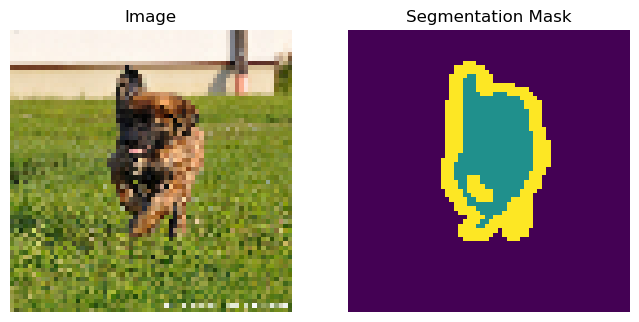

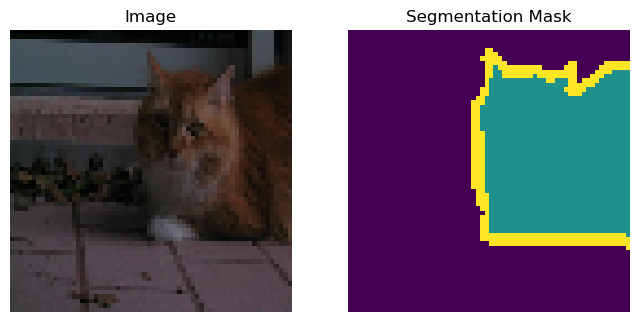

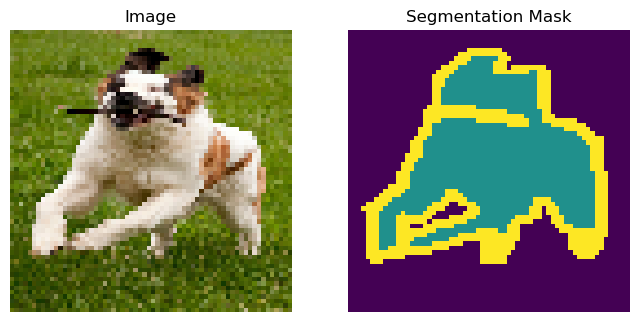

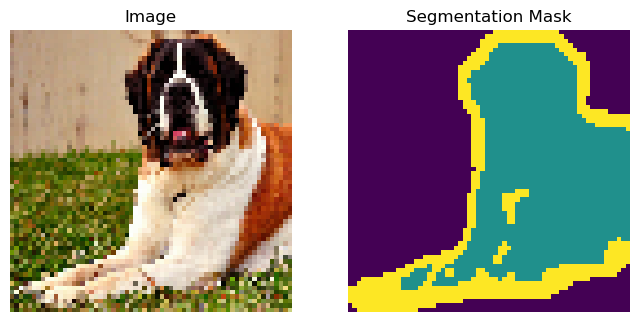

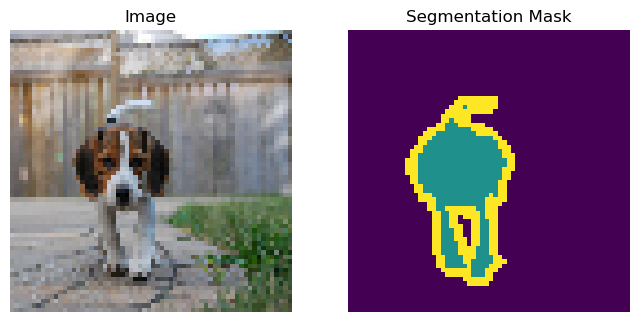

In [38]:
# Visualize 5 examples from the training split
visualize_image_and_mask(ds_3c_train)

In [39]:
# your code here
# create & compile the model
model_unet = deep_cnn_model(num_classes = 3)
model_unet.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',  # Suitable for integer masks with 2 classes
    metrics=['accuracy', iou_metric]  # Reusing your custom iou_metric defined earlier
)
model_unet.summary()

# train and validation datasets
train_dataset = ds_3c_train.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = ds_3c_val.batch(32).prefetch(tf.data.AUTOTUNE)

# fit model
history_model_unet = model_unet.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,  
    verbose=1
)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_151 (Conv2D)         (None, 64, 64, 64)           1792      ['input_3[0][0]']             
                                                                                                  
 batch_normalization_15 (Ba  (None, 64, 64, 64)           256       ['conv2d_151[0][0]']          
 tchNormalization)                                                                                
                                                                                                  
 activation_15 (Activation)  (None, 64, 64, 64)           0         ['batch_normalization_15

Run the cell below to visualize your loss and accuracy.

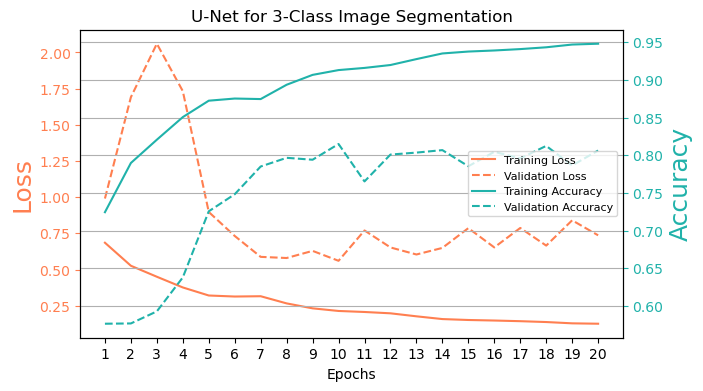

In [40]:
plot_training_history(history_model_unet,
                      model_name="U-Net for 3-Class Image Segmentation")

Run the cell below, and you will see your segmentation result. You can run the cell multiple times to see different result sets.

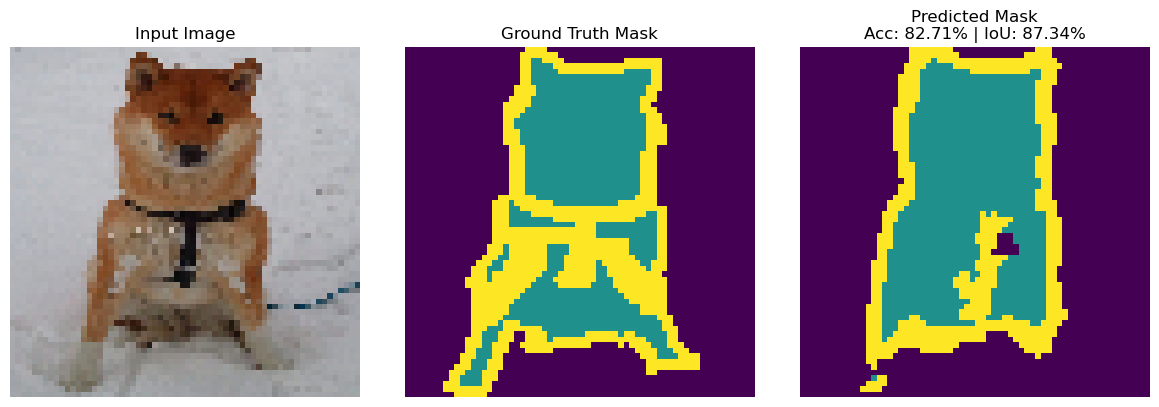

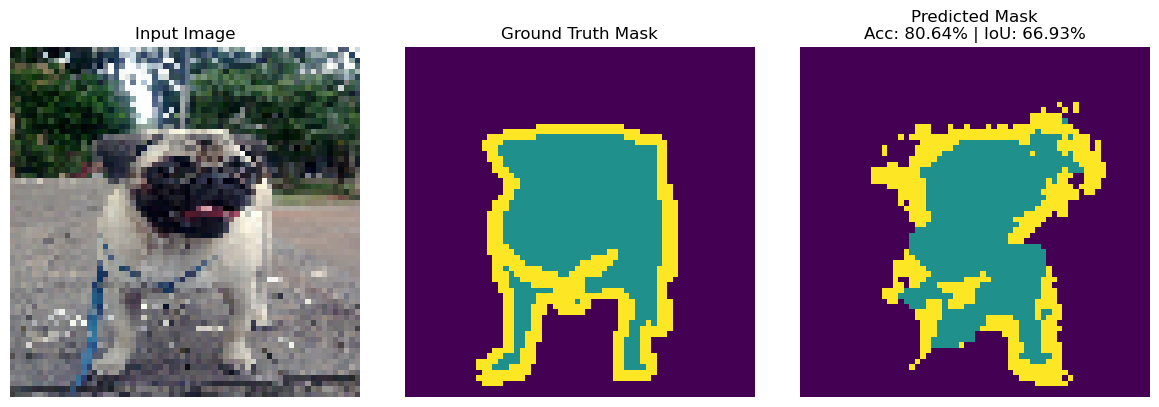

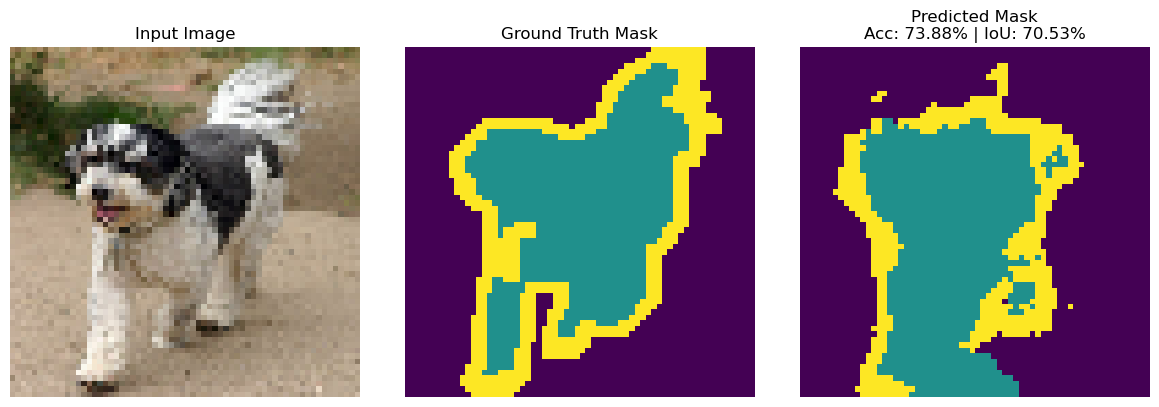

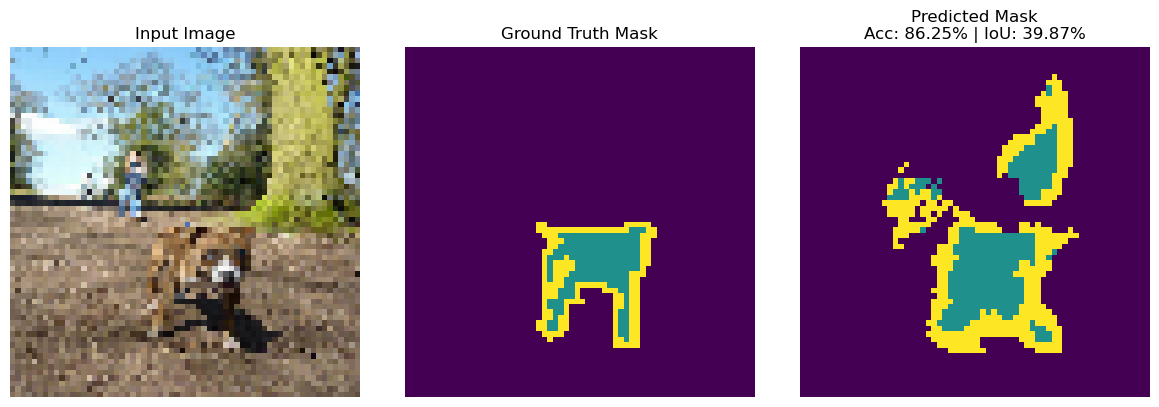

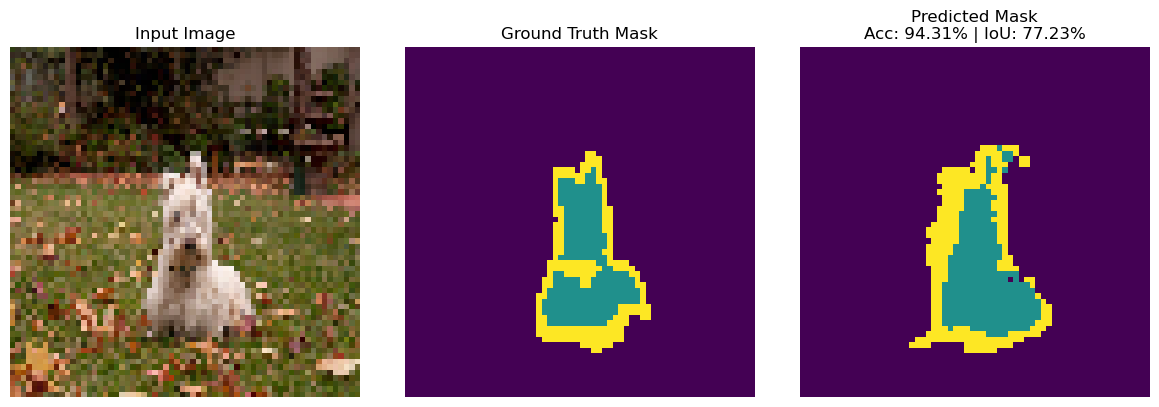

In [41]:
visualize_predictions(ds_3c_test, model_unet, show_iou=True)

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Wrap-up</b>

* In a few sentences, please describe the aspect(s) of the assignment you found most challenging. This could be conceptual and/or related to coding and implementation.

* How many hours did you spend working on this assignment? Store this as an int or float in `hours_spent_on_hw`. If you worked on the project in a group, report the *average* time spent per person.
    </div>

# Answer

The most challenging aspect of this assignment was implementing `model_deepcnn` in Q3. Since it was a segmentation task rather than a classification problem, it introduced additional complexity—such as my predicted masks initially being all black to match the background, which took many hours to debug. In Q2, implementing my GoogleNet-inspired model was also quite challenging, particularly debugging the `Concatenate` layers within the inception block. Additionally, finding a suitable image, processing it correctly, and displaying the results added to the difficulty. Understanding the U-Net architecture and combining it with ResNet to create my final model was another significant conceptual and implementation challenge.

In [42]:
hours_spent_on_hw = 12

In [43]:
grader.check("wrapup")

wrapup results: All test cases passed!

In [44]:
time_end = time.time()
print(f"It took {(time_end - time_start)/60:.2f} minutes for this notebook to run")

It took 10.05 minutes for this notebook to run


**This concludes HW3. Thank you!**